<a href="https://colab.research.google.com/github/Yuvaraj0001/EVA7_Assignments/blob/main/Session%202.5/Assignment_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random

## Building the Network

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)    # input-28x28  Output-28x28   RF-3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   # input-28x28  Output-28x28   RF-5x5
        self.pool1 = nn.MaxPool2d(2, 2)                # input-28x28  Output-14x14   RF-10x10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # input-14x14  Output-14x14   RF-12x12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # input-14x14  Output-14x14   RF-14x14
        self.pool2 = nn.MaxPool2d(2, 2)                # input-14x14  Output-7x7     RF-28x28
        self.conv5 = nn.Conv2d(256, 512, 3)            # input-7x7    Output-5x5     RF-30x30
        self.conv6 = nn.Conv2d(512, 1024, 3)           # input-5x5    Output-3x3     RF-32x32
        self.conv7 = nn.Conv2d(1024, 10, 3)            # input-3x3    Output-1x1     RF-34x34

        self.fc1 = nn.Linear(10+10, 128)               # Concatenate two inputs           
        self.fc2 = nn.Linear(128, 19)


    def forward(self, image, randomNumber):
        # 1st Step
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image))))) # 1st convolutional layer followed by relu given to 2nd convolutional layer and output passed to maxpooling
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))     # 3rd convolutional layer followed by relu given to 4th convolutional layer and output passed to maxpooling
        x = F.relu(self.conv6(F.relu(self.conv5(x))))                 # Result from above passed to two sets of convolution and relu activation operation
        x = self.conv7(x)                                             # The output from 6th convolutional layer is passed to a 7th convoluional linear layer
        x = x.view(-1, 10)                                            # The flatten's all of the tensor's elements into a single dimension.

        # 2nd Step
        x1 = torch.cat((x, randomNumber), dim=1)                      # concatenate second input (random number) to the output from flattening
        x1 = F.relu(self.fc1(x1))                                     # train network on dense layer
        x1 = self.fc2(x1)                                           

        # Model returns two outputs:
        # 1. the "number" that was represented by the MNIST image 
        # 2. the "sum" of this number with the random number and the input image to the network
        return F.log_softmax(x, dim = 1), F.log_softmax(x1, dim = 1)
  

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
)

## Random number dataset generation

In [4]:
class Random_Num_Dataset(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    randomNo = random.randint(0,9)

    #Create one hot encoding for random number 
    one_hotrandomNo = torch.nn.functional.one_hot(torch.arange(0, 10))

    #add actual label and random number
    sum = label + randomNo
    return image, label, one_hotrandomNo[randomNo], sum

  def __len__(self):
    return len(self.MNISTDataset)

## Preparing the MNIST Dataset

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Load and transform data
MNIST_train = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=train_transforms)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=test_transforms)

In [7]:
# Load and transform data
train_dataset = Random_Num_Dataset(MNIST_trainset)
val_dataset = Random_Num_Dataset(MNIST_valset)
test_dataset = Random_Num_Dataset(MNIST_testset)
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128)
test_loader = DataLoader(test_dataset,batch_size=128)

## Training and Testing Funtions

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (data, target, random_number, sum) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        sum = sum.type(torch.LongTensor)
        data, target, sum = data.to(device), target.to(device), sum.to(device)
        # zero out the gradients
        optimizer.zero_grad()
        output, sum_output = model(data,random_number.to(device))
        # compute the loss 
        mnist_loss = F.nll_loss(output, target)
        sum_loss = F.nll_loss(sum_output, sum)
        loss= mnist_loss + sum_loss
        epoch_loss += loss.item()
        # compute the backward gradients
        loss.backward()
        # update the optimizer params
        optimizer.step()
    print('Train set: loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss

def test(model, device, test_loader,test_type='Val'):
    model.eval()
    test_loss = 0   
    correct_mnist = 0
    correct_sum = 0
    with torch.no_grad():
        for (data, target, random_number, sum) in test_loader:
            target = target.type(torch.LongTensor)
            sum = sum.type(torch.LongTensor)
            data, target,sum = data.to(device), target.to(device), sum.to(device)
            output, sum_output = model(data,random_number.to(device))
            test_loss += (F.nll_loss(output, target, reduction='sum').item() + F.nll_loss(sum_output, sum, reduction='sum').item())/2
            mnist_pred = output.argmax(dim=1, keepdim=True)
            sum_pred = sum_output.argmax(dim=1, keepdim=True)
            correct_mnist += mnist_pred.eq(target.view_as(mnist_pred)).sum().item()
            correct_sum += sum_pred.eq(sum.view_as(sum_pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'{test_type} set: loss: {test_loss:.3f}, MNist Accuracy:{100. * correct_mnist/len(test_loader.dataset)}, Sum_Accuracy:{100. * correct_sum/len(test_loader.dataset)}')
    return test_loss

In [10]:
# move the model to the specified device
model = Net().to(device)
# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# set the number of epochs to train for
num_epoch = 5

train_loss_values = []
valid_loss_values = []
# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss=train_loss=train(model, device, train_loader, optimizer, epoch)
    valid_loss=test(model, device, val_loader)
    # test the model
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)


Epoch 1 : 
Train set: loss: 2.0403
Val set: loss: 1.040, MNist Accuracy:98.26, Sum_Accuracy:35.22

Epoch 2 : 
Train set: loss: 1.2970
Val set: loss: 0.572, MNist Accuracy:98.76, Sum_Accuracy:89.2

Epoch 3 : 
Train set: loss: 0.3346
Val set: loss: 0.187, MNist Accuracy:98.92, Sum_Accuracy:98.52

Epoch 4 : 
Train set: loss: 0.1684
Val set: loss: 0.105, MNist Accuracy:98.88, Sum_Accuracy:98.62

Epoch 5 : 
Train set: loss: 0.0975
Val set: loss: 0.065, MNist Accuracy:99.14, Sum_Accuracy:99.0


# Demo 

In [11]:
def demo_prediction(image,rnum):

    rnum_ohe = torch.zeros(11).long()
    rnum_ohe[rnum] = 1
    rnum_ohe = rnum_ohe[:-1]

    output_1,output_2 = model(image.unsqueeze(dim=1).to(device),rnum_ohe.reshape(-1,10).to(device))

    mnist_pred = output_1.argmax(dim=1, keepdim=True)
    sum_pred = output_2.argmax(dim=1, keepdim=True)
    plt.imshow(image.cpu().numpy().squeeze(),cmap='gray')
    print('Mnist Prediction:',mnist_pred.item())
    print('Random Number Generated:',rnum)
    print('Sum:',mnist_pred.item()+rnum)
    return mnist_pred, sum_pred

Mnist Prediction: 9
Random Number Generated: 6
Sum: 15


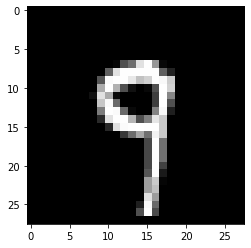

In [12]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =demo_prediction(image,rnum)